In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
def evaluate(X_train, y_train, ax=None):
    estimator = xgb.XGBRegressor(random_state=0)
    score = np.sqrt(-cross_val_score(estimator, X_train, y=y_train,
               scoring='neg_mean_squared_error',
               cv=5,
              ))
    estimator.fit(X_train, y_train)
    xgb.plot_importance(estimator, ax=ax)
    return np.mean(score), np.std(score)

In [7]:
def test():
    df_train = read_train_csv()
    duplicate_index = np.array([395, 126, 1215, 1886, 2075, 353, 308, 2154, 531, 1379, 2319, 2337, 2370, 2333])
    df_train.drop(duplicate_index - 1, axis=0, inplace=True)
    
    X_train = df_train.drop(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev',], axis=1)    
    y_fe_train = np.log1p(df_train['formation_energy_ev_natom'].values)
    y_bg_train = np.log1p(df_train['bandgap_energy_ev'].values)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 15))
    fe_mean, fe_std = evaluate(X_train, y_fe_train, ax=ax1)
    bg_mean, bg_std = evaluate(X_train, y_bg_train, ax=ax2)
    print('bandgap   : {:.4f}  {:.5f}'.format(fe_mean, fe_std))
    print('formation : {:.4f}  {:.5f}'.format(bg_mean, bg_std))
    print('total     : {:.4f}  {:.5f}'.format((fe_mean + bg_mean) / 2, (fe_std + bg_std) / 2))

bandgap   : 0.0257  0.00080
formation : 0.0806  0.00144
total     : 0.0531  0.00112


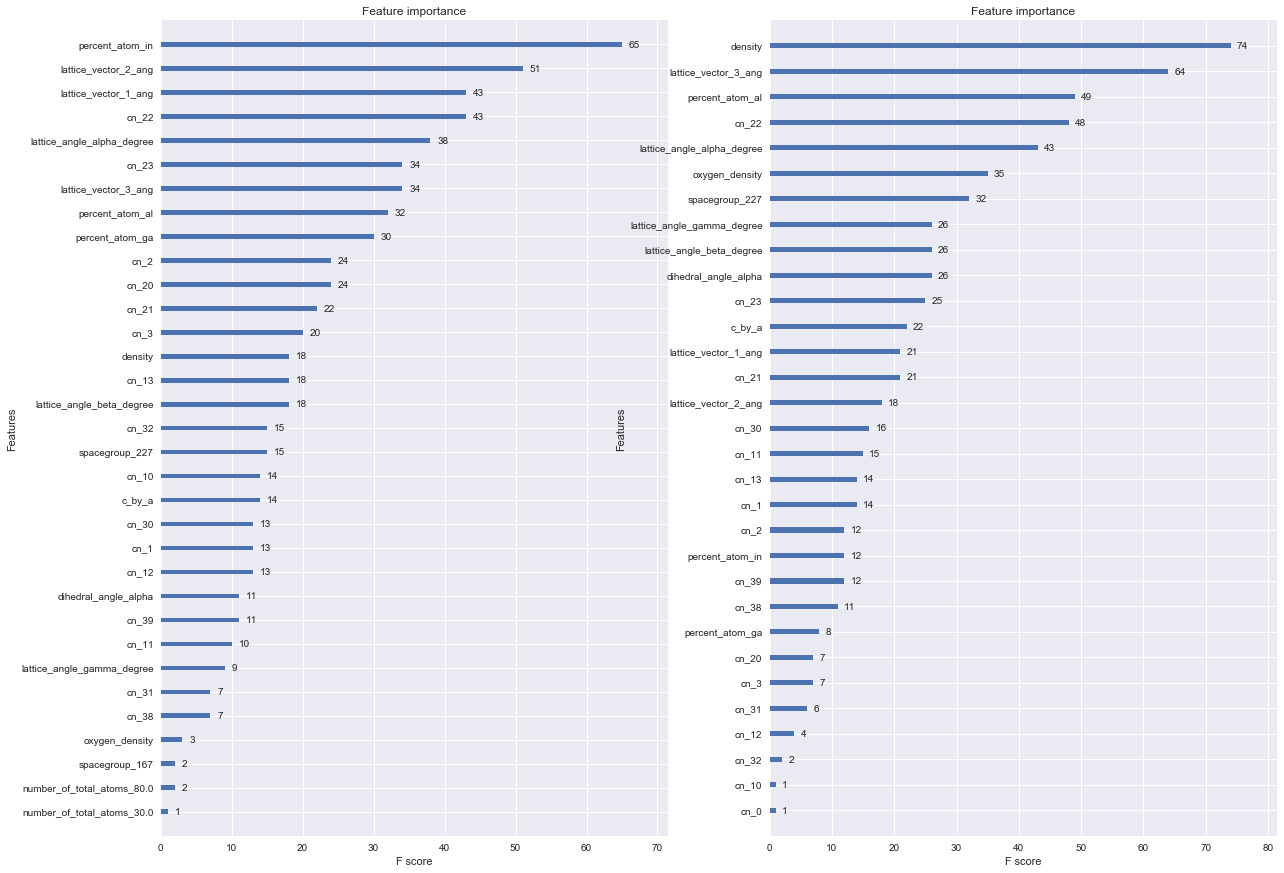

In [10]:
test()

In [35]:
def read_train_csv():
    df = pd.read_csv('data/train.csv')

    df = df.round({'lattice_vector_1_ang': 4,
                   'lattice_vector_2_ang': 4,
                   'lattice_vector_3_ang': 4,
                   'lattice_angle_alpha_degree': 3,
                   'lattice_angle_beta_degree': 3,
                   'lattice_angle_gamma_degree': 3})

    alpha = np.radians(df['lattice_angle_alpha_degree'])
    beta = np.radians(df['lattice_angle_beta_degree'])
    gamma = np.radians(df['lattice_angle_gamma_degree'])
    
    volume =  df['lattice_vector_1_ang'] * df['lattice_vector_2_ang'] * df['lattice_vector_3_ang'] * np.sin(alpha) * np.sin(beta) * np.sin(gamma)
    df['density'] = df['number_of_total_atoms'] / volume
    df['dihedral_angle_alpha'] = (np.cos(beta) * np.cos(gamma) - np.cos(alpha)) / np.sin(beta) / np.cos(gamma)
    df['c_by_a'] = df['lattice_vector_3_ang'] / df['lattice_vector_1_ang']

    df['hoge'] = df['percent_atom_in'] * df['number_of_total_atoms']
    
    spacegroup = pd.get_dummies(df['spacegroup'].astype('str'), drop_first=True, prefix='spacegroup')

    total_atoms = pd.get_dummies(df['number_of_total_atoms'].astype('str'), drop_first=True, prefix='number_of_total_atoms')

    df_oxygen_ave = pd.DataFrame(joblib.load('data/oxygen_arr.train'), columns=['oxygen_density'])

    coo_mat = joblib.load('data/coo_mat.train')
    df_CN = pd.DataFrame(coo_mat, columns=['cn_{}'.format(i) for i in range(coo_mat.shape[1])]).drop(['cn_24'], axis=1)
    
    df2 = pd.concat([df, spacegroup, total_atoms, df_oxygen_ave, df_CN], axis=1)
    df2.drop(['spacegroup', 'number_of_total_atoms'], axis=1, inplace=True)
    
    return df2

bandgap   : 0.0256  0.00069
formation : 0.0806  0.00102
total     : 0.0531  0.00086


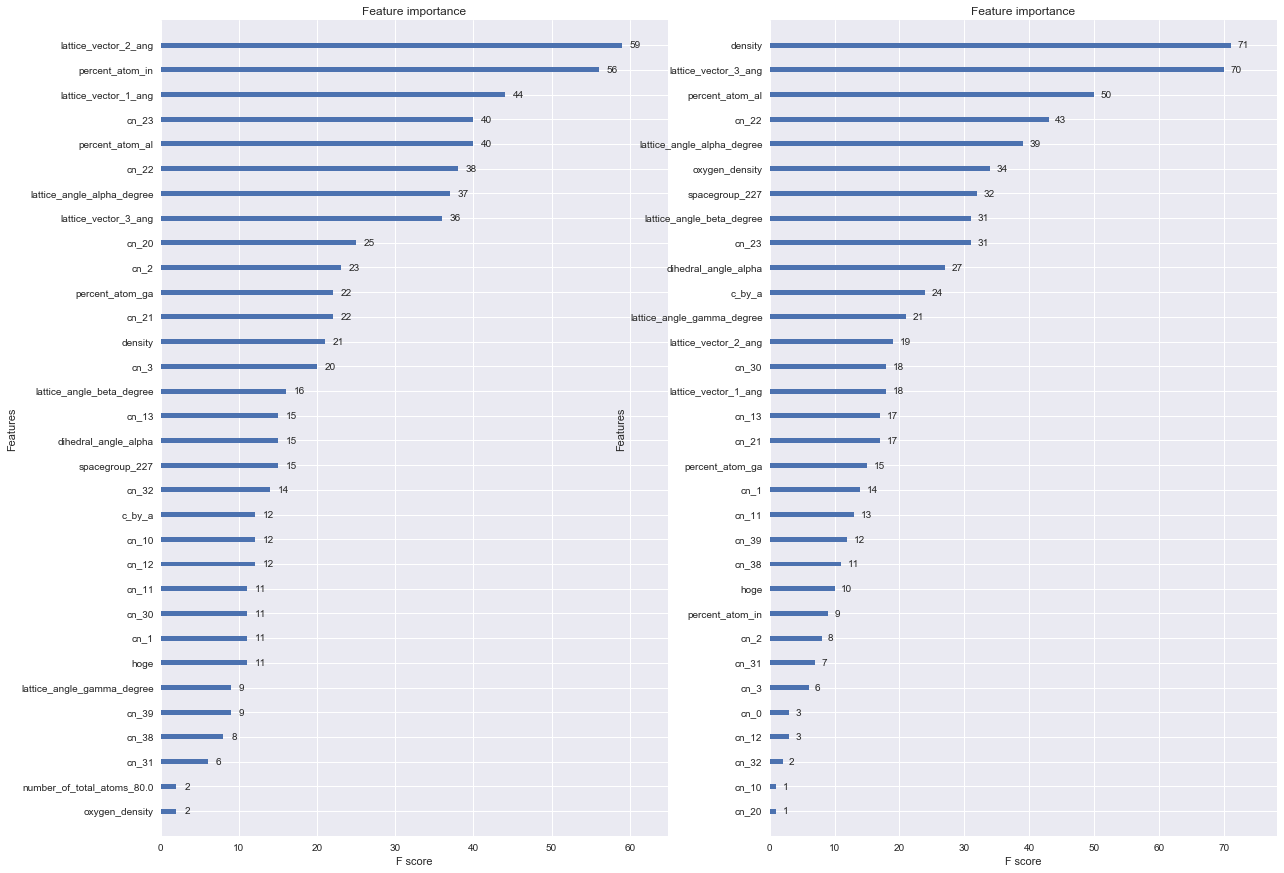

In [36]:
test()